In [1]:
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.set_default_dtype(torch.float64)
torch.autograd.set_detect_anomaly(True)

cuda


In [3]:
from pyspark.sql import SparkSession

# Tạo SparkSession
spark = SparkSession.builder \
    .appName("Read CSV Example") \
    .getOrCreate()

# Đọc file CSV
df = spark.read.csv("origindata.csv", header=True, inferSchema=True)

# Hiển thị dữ liệu
df.show()


+--------+---------+-----------+----------+-----------+---------+------------------+------------+----------+-------------------+-----------------------+---------------------+------------------------------+------------------------+----------------------+-------------------------------+-----------------+------------+------------------------+-------------+-------------------------+---------------------+---------------------------------+----------------------+----------------------------------+-----------+---------+------------------------+----------------------+------------------+-------------------------------+-------------+--------------+-----------+------------------+-----------------+-----------------------+--------------+----------------+-------------------------+------------------------------+-----------------------------+-----------------------------------+--------------------------+-------------------------------------+------------------------------+-------------------------------

In [4]:
from pyspark.sql.functions import to_date

# Chuyển cột 'date' sang kiểu ngày (datetime)
df = df.withColumn('date', to_date('date', 'yyyy-MM-dd'))

# Sắp xếp theo 'location' và 'date'
df = df.orderBy(['location', 'date'])

In [5]:
from pyspark.sql.functions import col, count, when, mean
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType, IntegerType, StringType

# --- 1. Loại bỏ các cột có hơn 70% giá trị bị thiếu ---
row_count = df.count()
null_ratios = df.select([
    (count(when(col(c).isNull(), c)) / row_count).alias(c) for c in df.columns
])
null_ratios_dict = null_ratios.collect()[0].asDict()
columns_to_keep = [c for c, ratio in null_ratios_dict.items() if ratio < 0.7]
df = df.select(columns_to_keep)

# --- 2. Điền giá trị thiếu cho các cột số bằng trung bình ---
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (DoubleType, IntegerType))]
for col_name in numeric_cols:
    mean_val = df.select(mean(col(col_name))).collect()[0][0]
    if mean_val is not None:
        df = df.fillna({col_name: mean_val})

# --- 3. Điền giá trị thiếu cho các cột chuỗi bằng mode (giá trị phổ biến nhất) ---
string_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]
for col_name in string_cols:
    mode_val = df.groupBy(col_name).count().orderBy('count', ascending=False).first()
    if mode_val is not None:
        df = df.fillna({col_name: mode_val[0]})


In [6]:
df.head()

Row(iso_code='AFG', continent='Asia', location='Afghanistan', date=datetime.date(2020, 1, 5), total_cases=0, new_cases=0, new_cases_smoothed=8041.02576410559, total_deaths=0, new_deaths=0, new_deaths_smoothed=72.06082842751303, total_cases_per_million=0.0, new_cases_per_million=0.0, new_cases_smoothed_per_million=122.71385223352105, total_deaths_per_million=0.0, new_deaths_per_million=0.0, new_deaths_smoothed_per_million=0.7645298965747974, reproduction_rate=0.9114953710967834, new_vaccinations_smoothed=283875.815135185, new_vaccinations_smoothed_per_million=1851.477595639623, new_people_vaccinated_smoothed=106070.69886614944, new_people_vaccinated_smoothed_per_hundred=0.07467839543757489, stringency_index=0.0, population_density=54.42, median_age=18.6, aged_65_older=2.58, aged_70_older=1.34, gdp_per_capita=1803.99, extreme_poverty=13.924729240173251, cardiovasc_death_rate=597.03, diabetes_prevalence=9.59, female_smokers=10.772437926086475, male_smokers=33.09775758048625, handwashing_f

In [7]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lead

# Tạo window theo từng quốc gia, sắp xếp theo ngày
window_spec = Window.partitionBy('location').orderBy('date')

# Thêm cột new_cases_next_day
df = df.withColumn('new_cases_next_day', lead('new_cases').over(window_spec))


In [8]:
from pyspark.sql.types import DoubleType, IntegerType

# Lấy danh sách các cột kiểu số
numerical_cols = [
    field.name for field in df.schema.fields 
    if isinstance(field.dataType, (DoubleType, IntegerType))
    and field.name not in ['new_cases_next_day', 'population']
]


In [9]:
features_to_lag = [
    'new_cases_smoothed', 'total_deaths', 'new_deaths_smoothed','total_cases'
]

In [10]:
actual_features_to_lag = [col for col in features_to_lag if col in df.columns]


In [11]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

# Tạo cửa sổ phân nhóm theo location, sắp xếp theo ngày
window_spec = Window.partitionBy('location').orderBy('date')

# Tạo các cột lag
for col_name in actual_features_to_lag:
    if col_name in numerical_cols:
        for i in range(1, 6):
            df = df.withColumn(f"{col_name}_lag_{i}", lag(col_name, i).over(window_spec))


In [12]:
# Drop toàn bộ các hàng có giá trị null (do tạo cột lag)
df = df.na.drop()

# Loại bỏ các cột gốc đã được tạo lag
columns_to_drop = [col for col in actual_features_to_lag if col in df.columns]
df = df.drop(*columns_to_drop)


In [14]:
df.printSchema()

root
 |-- iso_code: string (nullable = false)
 |-- continent: string (nullable = false)
 |-- location: string (nullable = false)
 |-- date: date (nullable = true)
 |-- new_cases: integer (nullable = true)
 |-- new_deaths: integer (nullable = true)
 |-- total_cases_per_million: double (nullable = false)
 |-- new_cases_per_million: double (nullable = false)
 |-- new_cases_smoothed_per_million: double (nullable = false)
 |-- total_deaths_per_million: double (nullable = false)
 |-- new_deaths_per_million: double (nullable = false)
 |-- new_deaths_smoothed_per_million: double (nullable = false)
 |-- reproduction_rate: double (nullable = false)
 |-- new_vaccinations_smoothed: double (nullable = false)
 |-- new_vaccinations_smoothed_per_million: double (nullable = false)
 |-- new_people_vaccinated_smoothed: double (nullable = false)
 |-- new_people_vaccinated_smoothed_per_hundred: double (nullable = false)
 |-- stringency_index: double (nullable = false)
 |-- population_density: double (nulla

In [23]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import NumericType

# 1. Lấy tất cả các cột kiểu số (int, float, double)
numerical_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# 2. Đảm bảo rằng cột target tồn tại trong tập dữ liệu
if 'new_cases_next_day' not in numerical_cols:
    raise ValueError("Cột 'new_cases_next_day' không tồn tại trong DataFrame!")

# 3. Tạo vector đặc trưng
assembler = VectorAssembler(inputCols=numerical_cols, outputCol='features')
df_vector = assembler.transform(df.select(numerical_cols)).select('features')

# 4. Tính ma trận tương quan Pearson
correlation_matrix = Correlation.corr(df_vector, 'features', method='pearson').head()[0]
cor_matrix_array = correlation_matrix.toArray()

# 5. Chuyển về pandas DataFrame giống như pandas.corr()
cor_df = pd.DataFrame(cor_matrix_array, columns=numerical_cols, index=numerical_cols)

# 6. Lấy tương quan với cột mục tiêu 'new_cases_next_day'
correlations_with_target = cor_df['new_cases_next_day'].sort_values(ascending=False)

print("--- Correlation matrix ---")
print(correlations_with_target)
print("\n" + "="*80 + "\n")

--- Correlation matrix ---
new_cases_next_day                            1.000000
new_cases_smoothed_lag_1                      0.319210
new_cases_smoothed_lag_3                      0.319208
new_cases_smoothed_lag_5                      0.319206
new_cases_smoothed_lag_2                      0.232756
new_cases_smoothed_lag_4                      0.232754
new_deaths_smoothed_lag_1                     0.181250
new_deaths_smoothed_lag_3                     0.181249
new_deaths_smoothed_lag_5                     0.181247
total_deaths_lag_5                            0.154165
total_deaths_lag_3                            0.154145
total_deaths_lag_1                            0.154124
new_vaccinations_smoothed                     0.144343
new_deaths_smoothed_lag_2                     0.139626
new_deaths_smoothed_lag_4                     0.139624
population                                    0.139224
total_cases_lag_5                             0.122134
total_cases_lag_3                     

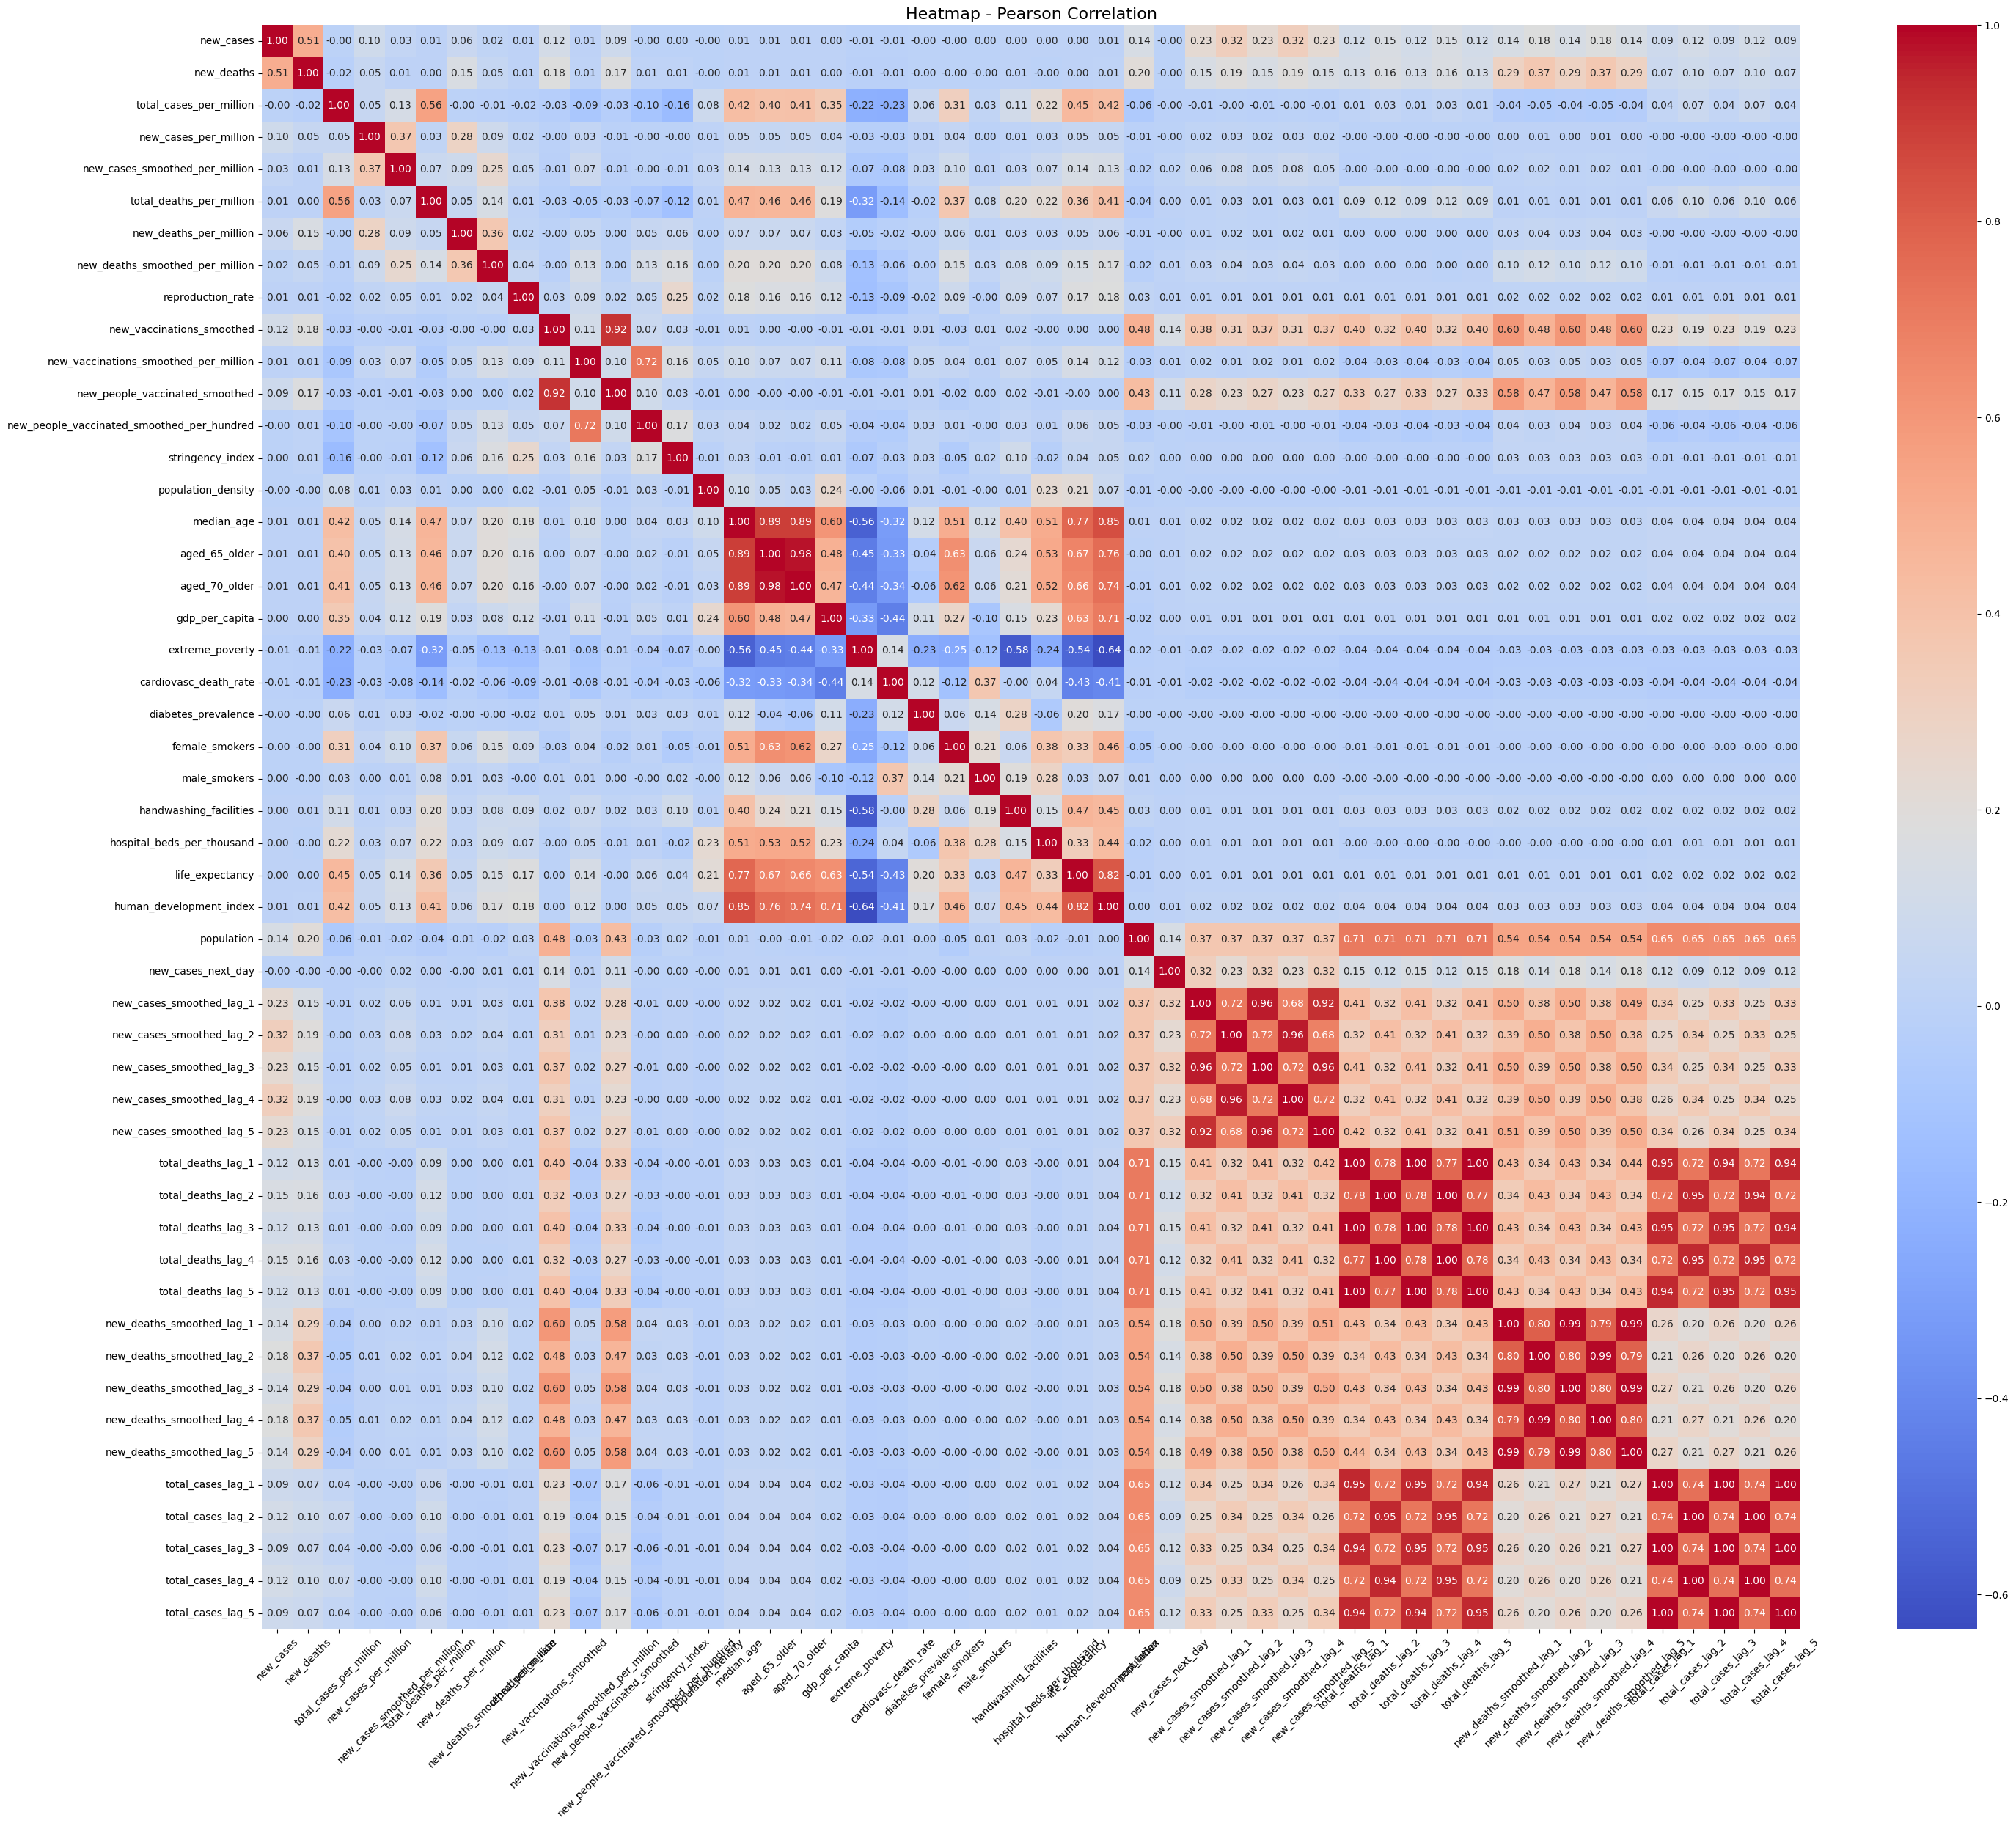

In [24]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import NumericType
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn các cột dạng số
num_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, NumericType)]

# Tạo vector đặc trưng
vec_assembler = VectorAssembler(inputCols=num_cols, outputCol="features")
df_vec = vec_assembler.transform(df).select("features")

# Tính ma trận tương quan Pearson
corr_mat = Correlation.corr(df_vec, "features", "pearson").head()[0].toArray()

# Vẽ heatmap
plt.figure(figsize=(30, 25))
sns.heatmap(corr_mat, xticklabels=num_cols, yticklabels=num_cols, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Heatmap - Pearson Correlation", fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


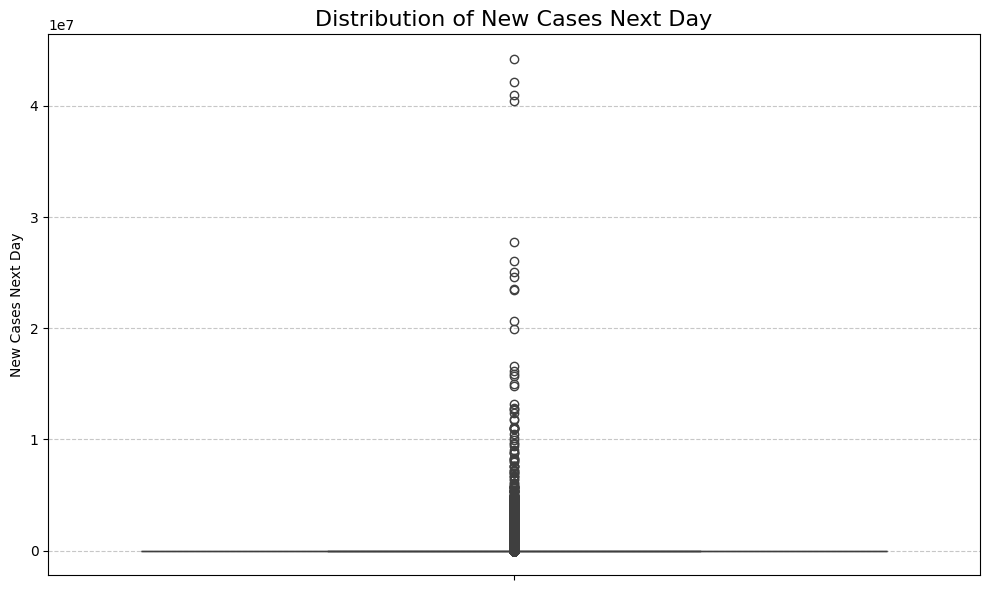

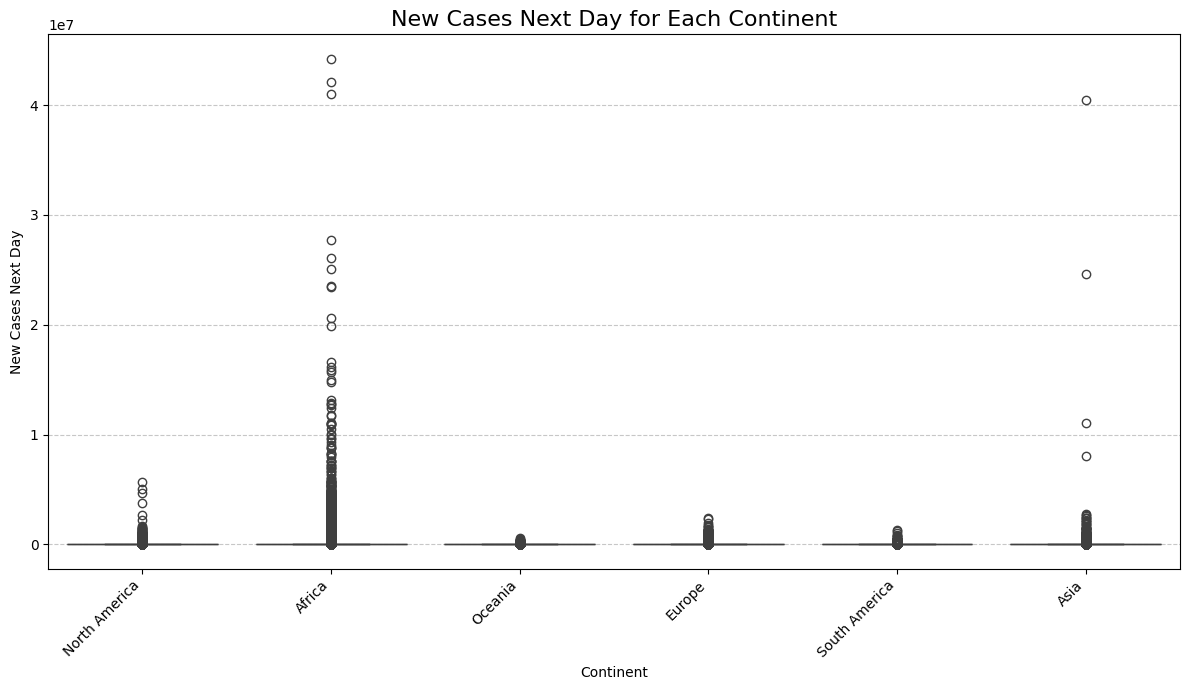

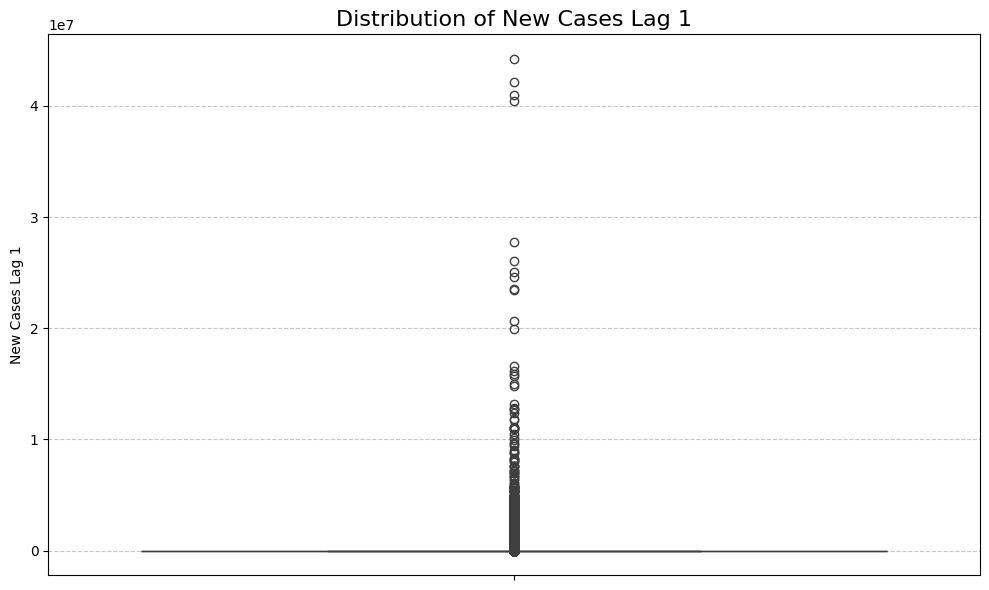

In [26]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag
import matplotlib.pyplot as plt
import seaborn as sns

# Tạo các cột lag
window_spec = Window.partitionBy("location").orderBy("date")
df = df.withColumn("new_cases_lag_1", lag("new_cases", 1).over(window_spec))
df = df.withColumn("new_cases_next_day", lag("new_cases", -1).over(window_spec))

# Chuyển sang pandas
pandas_df = df.select('new_cases_next_day', 'continent', 'new_cases_lag_1').toPandas()
pandas_df = pandas_df.dropna(subset=['new_cases_next_day', 'new_cases_lag_1', 'continent'])

# Hàm vẽ boxplot
def plot_boxplot(y, data, title, ylabel, x=None, xlabel=None, figsize=(10,6), rotate_xticks=False):
    plt.figure(figsize=figsize)
    if x:
        sns.boxplot(x=x, y=y, data=data)
        plt.xlabel(xlabel if xlabel else x)
    else:
        sns.boxplot(y=y, data=data)
    plt.title(title, fontsize=16)
    plt.ylabel(ylabel)
    if rotate_xticks:
        plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Vẽ biểu đồ
plot_boxplot(y='new_cases_next_day', data=pandas_df,
             title='Distribution of New Cases Next Day',
             ylabel='New Cases Next Day')

plot_boxplot(y='new_cases_next_day', x='continent', data=pandas_df,
             title='New Cases Next Day for Each Continent',
             ylabel='New Cases Next Day', xlabel='Continent',
             figsize=(12,7), rotate_xticks=True)

plot_boxplot(y='new_cases_lag_1', data=pandas_df,
             title='Distribution of New Cases Lag 1',
             ylabel='New Cases Lag 1')


In [27]:
output_csv_filename = 'data/processed_country_data.csv'
df.to_csv(output_csv_filename, index=False)

AttributeError: 'DataFrame' object has no attribute 'to_csv'